In [2]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from pyarrow import feather
import seaborn as sns


plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (7, 7)

In [3]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [4]:
os.getcwd()

'C:\\Users\\Bio_Psych\\Desktop\\Deniz\\tf-cpu\\p1_generalization'

In [5]:
# CONFIG

PATH_HUMAN_DATA = 'data/human_raw_data/'
HUMAN_DATA_NAME = 'data_chakroun_wiehler.csv'

# number of human subjects
N_SUBS = 31
# number of trials (human & RNN)
N_TRIALS = 300
# number of bandits
N_BANDITS = 4

# path tp RNN data
PATH_RNN_DATA ='data/rnn_raw_data/'
RNN_FILE_NAME = 'lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'

# number of RNN instances
N_IDS = 30
# number of random walk instances
N_WALKS = 3

In [6]:
# function to calculate unique bandit heuristic

def get_unique_bandit_heuristic(my_choice, choice):
    
    n_trials = len(choice)
    other_choices = []
    unq_b_vec = np.zeros(n_trials)

    for t in range(n_trials):
        if choice[t] != -1: # if -1 choice is invalid
            if choice[t] != my_choice:

                other_choices.append(choice[t])
                unq_b_vec[t] = len(np.unique(other_choices))

            if choice[t] == my_choice:

                other_choices = []
                unq_b_vec[t] = 0
                
    return(unq_b_vec)

In [7]:
### Human
unq_bandit_counts_human = np.zeros([1,3])
human_df = pd.read_csv(open(PATH_HUMAN_DATA + HUMAN_DATA_NAME, 'rb'), index_col=0)

for sub in range(1, N_SUBS + 1):
    
    sub_df = human_df.loc[human_df.vp == sub,:]
    sub_df['choice'] = sub_df['choice'].values-1

    # use only valid choices
    sub_df = sub_df.loc[sub_df['choice']!=-1,:]
    choice = sub_df['choice'].to_numpy()

    is_switch = [int(choice[t] != choice[t-1]) for t in range(1, len(choice)) if choice[t] != -1]
    is_switch = np.insert(is_switch, 0, 0) # insert leading 0, first element can't be switch
    sub_df['is_switch'] = is_switch

    # uncertainty value at t
    unq_bandit_array = np.zeros([len(choice),N_BANDITS])
    # shift 1 to get uncertainty value t-1 for choice t
    shifted_unq_bandit_array = np.zeros([len(choice),N_BANDITS])

    for b in range(N_BANDITS):
        unq_bandit_array[:,b] = get_unique_bandit_heuristic(my_choice = b, choice = choice)
        shifted_unq_bandit_array[:,b] = pd.Series(unq_bandit_array[:,b]).shift(1)

    # get shifted uncertainty of chosen actions
    lagged_ch_unc = [shifted_unq_bandit_array[t,:][choice[t]] for t in range(len(choice))]

    # get uncertainty of switch trials    
    switch_indices = np.where(sub_df['is_switch'] == 1)    
    n_switches = np.shape(switch_indices)[1]
    ch_unc_at_switch = np.array(lagged_ch_unc)[switch_indices]

    # return counts
    _, counts = np.unique(ch_unc_at_switch, return_counts=True)

    # append to final array
    unq_bandit_counts_human = np.vstack((unq_bandit_counts_human, counts/n_switches)) # normalize counts with n_switches

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [8]:
### RNN

unq_bandit_counts_rnn = np.zeros([1,3])

for id_ in range(N_IDS):
    for walk in range(1,N_WALKS + 1):

        d = pickle.load(open(PATH_RNN_DATA + RNN_FILE_NAME.format(id_, walk), 'rb'))
        rnn_df = d.reset_index()
        choice = rnn_df['choice'].values

        # uncertainty value at t
        unq_bandit_array = np.zeros([len(choice),N_BANDITS])
        # shift 1 to get uncertainty value t-1 for choice t
        shifted_unq_bandit_array = np.zeros([len(choice),N_BANDITS])

        for b in range(N_BANDITS):
            unq_bandit_array[:,b] = get_unique_bandit_heuristic(my_choice = b, choice = choice)
            shifted_unq_bandit_array[:,b] = pd.Series(unq_bandit_array[:,b]).shift(1)

        # get shifted uncertainty of chosen actions
        lagged_ch_unc = [shifted_unq_bandit_array[t,:][choice[t]] for t in range(len(choice))]

        # get uncertainty of switch trials    
        switch_indices = np.where(rnn_df['is_switch'] == 1)    
        n_switches = np.shape(switch_indices)[1]
        ch_unc_at_switch = np.array(lagged_ch_unc)[switch_indices]

        # return counts
        _, counts = np.unique(ch_unc_at_switch, return_counts=True)

        # append to final array
        unq_bandit_counts_rnn = np.vstack((unq_bandit_counts_rnn, counts/n_switches)) # normalize counts with n_switches


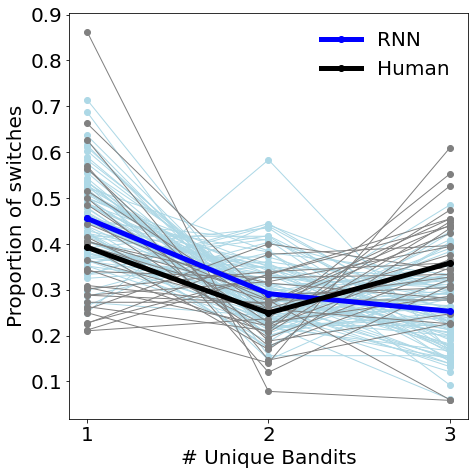

In [12]:
### plotting

for i in range(1,np.shape(unq_bandit_counts_rnn)[0]):
    plt.plot(range(1,N_BANDITS), unq_bandit_counts_rnn[i,:], '-o', c = 'lightblue', linewidth=1)
    
for i in range(1,np.shape(unq_bandit_counts_human)[0]):
    plt.plot(range(1,N_BANDITS), unq_bandit_counts_human[i,:], '-o', c = 'grey', linewidth=1)

    
plt.plot(range(1,N_BANDITS), np.mean(unq_bandit_counts_rnn[1:,:], axis = 0), '-o', c = 'blue',  linewidth=5.0, label = 'RNN')
plt.plot(range(1,N_BANDITS), np.mean(unq_bandit_counts_human[1:,:], axis = 0), '-o', c = 'black', linewidth=5.0, label = 'Human')
plt.ylabel("Proportion of switches")
plt.xlabel("# Unique Bandits")
plt.legend(frameon = False)
plt.xticks(np.arange(1,N_BANDITS, 1))

plt.tight_layout()
plt.savefig('../p1_generalization/plots/figure_2_D.png', dpi = 600)

array([1, 2, 3])